Escolhas dos Modelos:

RandomForestRegressor ou HistGradientBoostingRegressor levando em conta:
Desempenho: qual teve melhores métricas (MAE, RMSE, R² etc.).
Interpretabilidade: qual é mais fácil de entender, explicar ou extrair importância das variáveis.
Custo: tempo de treino, necessidade de hardware, complexidade para colocar em produção.

 justificativa para o caso:
Para o problema de previsão de crimes por bairro/mês utilizamos e comparamos dois modelos: RandomForestRegressor e HistGradientBoostingRegressor. Ambos são algoritmos de aprendizado supervisionado que lidam bem com dados heterogêneos e não lineares.

O HistGradientBoostingRegressor apresentou melhores métricas de desempenho (menor MAE/RMSE e maior R²) nos nossos testes, indicando maior capacidade preditiva. Além disso, ele lida bem com dados desbalanceados e aproveita os lags criados para capturar padrões temporais.

O RandomForestRegressor, por outro lado, é mais interpretável e mais rápido para treinar, com possibilidade de extrair importâncias das variáveis de forma direta, mas obteve resultados um pouco inferiores no conjunto de teste.

Considerando que nosso objetivo principal é maximizar a acurácia das previsões para apoiar decisões de segurança pública, aceitamos um pequeno aumento no custo computacional e na complexidade interpretativa para obter previsões mais precisas. Por isso, escolhemos o HistGradientBoostingRegressor como modelo final.

In [ ]:
import pandas as pd 
import numpy as np
from sklearn.model_selection import train_test_split 
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder 
from sklearn.compose import ColumnTransformer 
from sklearn.pipeline import Pipeline

In [2]:
df = pd.read_csv("C:/Users/55819/Downloads/Crime_prediction/data/raw/dataset_ocorrencias_delegacia_5.csv.")
df.head()

,id_ocorrencia,data_ocorrencia,bairro,tipo_crime,descricao_modus_operandi,arma_utilizada,quantidade_vitimas,quantidade_suspeitos,sexo_suspeito,idade_suspeito,orgao_responsavel,status_investigacao,latitude,longitude
0,OCR100000,2024-08-02 19:48:16.958668,Imbiribeira,Sequestro,Golpe Telefônico,Faca,2,0,Não Informado,53,Delegacia Casa Forte,Concluído,-8.111355,-34.943524
1,OCR100001,2022-10-29 19:48:16.958694,Boa Viagem,Homicídio,Fraude Online,Objeto Contundente,4,1,Não Informado,29,Delegacia Casa Forte,Arquivado,-8.082012,-34.861911
2,OCR100002,2023-03-12 19:48:16.958698,Santo Amaro,Furto,Invasão Residencial,Nenhum,1,4,Feminino,65,Delegacia Casa Forte,Arquivado,-8.096916,-34.898378
3,OCR100003,2025-04-18 19:48:16.958700,Afogados,Roubo,Arrombamento,Nenhum,1,4,Não Informado,30,Delegacia Torre,Concluído,-8.135066,-34.913460
4,OCR100004,2025-06-30 19:48:16.958702,Tamarineira,Roubo,Estupro Coletivo,Arma de Fogo,3,3,Masculino,20,Delegacia Casa Forte,Concluído,-8.074124,-34.933504


*Apagando colunas que não são relevantes para o modelo.*

In [3]:
df = df.drop(['id_ocorrencia', 'latitude', 'longitude', 'status_investigacao'], axis=1)
df.head()

,data_ocorrencia,bairro,tipo_crime,descricao_modus_operandi,arma_utilizada,quantidade_vitimas,quantidade_suspeitos,sexo_suspeito,idade_suspeito,orgao_responsavel
0,2024-08-02 19:48:16.958668,Imbiribeira,Sequestro,Golpe Telefônico,Faca,2,0,Não Informado,53,Delegacia Casa Forte
1,2022-10-29 19:48:16.958694,Boa Viagem,Homicídio,Fraude Online,Objeto Contundente,4,1,Não Informado,29,Delegacia Casa Forte
2,2023-03-12 19:48:16.958698,Santo Amaro,Furto,Invasão Residencial,Nenhum,1,4,Feminino,65,Delegacia Casa Forte
3,2025-04-18 19:48:16.958700,Afogados,Roubo,Arrombamento,Nenhum,1,4,Não Informado,30,Delegacia Torre
4,2025-06-30 19:48:16.958702,Tamarineira,Roubo,Estupro Coletivo,Arma de Fogo,3,3,Masculino,20,Delegacia Casa Forte


*Feature Engineering (Criação de Novas Variáveis) adicionando a variável ano e mes que pode ser útil para prever crimes com base no tempo*

In [5]:
df['data_ocorrencia'] = pd.to_datetime(df['data_ocorrencia'])


df["data_ocorrencia"] = pd.to_datetime(df["data_ocorrencia"])

# Criar novas colunas com partes da data
df["ano"] = df["data_ocorrencia"].dt.year
df["mes"] = df["data_ocorrencia"].dt.month
df["dia"] = df["data_ocorrencia"].dt.day
df["hora"] = df["data_ocorrencia"].dt.hour
df["minuto"] = df["data_ocorrencia"].dt.minute
df["segundo"] = df["data_ocorrencia"].dt.second

# Dia da semana (segunda=0, domingo=6)
df["dia_semana_num"] = df["data_ocorrencia"].dt.dayofweek


df["dia_semana_nome"] = df["data_ocorrencia"].dt.day_name()

df["dia_semana_nome"] = df["data_ocorrencia"].dt.day_name()

In [7]:
df.columns

Index(['data_ocorrencia', 'bairro', 'tipo_crime', 'descricao_modus_operandi',
       'arma_utilizada', 'quantidade_vitimas', 'quantidade_suspeitos',
       'sexo_suspeito', 'idade_suspeito', 'orgao_responsavel', 'ano', 'mes',
       'dia', 'hora', 'minuto', 'segundo', 'dia_semana_num',
       'dia_semana_nome'],
      dtype='object')

*Criar coluna para prever padrões em determinada época do ano*

In [ ]:
# Criar uma nova coluna com a estação do ano

def estacao(mes): 
    if mes in [12,1,2]: return "Verão" 
    elif mes in [3,4,5]: return "Outono" 
    elif mes in [6,7,8]: return "Inverno" 

    else: return "Primavera" 
    
df['estacao'] = df['mes'].apply(estacao)

*Filtrar apenas pelo tráfico de drogas.*

In [ ]:

df_trafico = df[df['tipo_crime'].str.contains("Tráfico", case=False, na=False)]

*Agrupar por bairro, ano e mês que são as feactures principais*

In [12]:
df_grouped = (
    df_trafico.groupby(['bairro', 'ano', 'mes'])
    .size()
    .reset_index(name='quantidade_crimes')
)

# Ordenar por bairro e tempo
df_grouped = df_grouped.sort_values(by=['bairro', 'ano', 'mes'])

*Essas variáveis de lag ajudam modelos de machine learning a entender padrões passados.*

*Exemplo: se você quer prever o número de crimes em setembro, pode usar o número de crimes em agosto (lag1) e julho (lag2) como variáveis preditoras.*

In [13]:
# Criar lags (histórico)
df_grouped['lag1'] = df_grouped.groupby('bairro')['quantidade_crimes'].shift(1)
df_grouped['lag2'] = df_grouped.groupby('bairro')['quantidade_crimes'].shift(2)
df_grouped = df_grouped.fillna(0)

*Separando o x e o y(targt)*

In [17]:
X = df_grouped[['bairro', 'ano', 'mes', 'lag1', 'lag2']]
y = df_grouped['quantidade_crimes']

*Gera todas as combinações possíveis de bairro, ano e mês.*

*Faz a junção (merge) dessas combinações com o DataFrame df_grouped (onde há os dados de crimes).*

*Preenche os valores ausentes (NaN) por 0, para tratar meses sem registros de crimes.*

*Cria as variáveis de lag (lag1 e lag2), que representam o histórico de crimes dos meses anteriores para cada bairro.*

In [25]:
# Criar todas as combinações de bairro, ano e mês
import itertools

bairros = df_trafico['bairro'].unique()
anos = df_grouped['ano'].unique()
meses = range(1,13)

all_combinations = pd.DataFrame(list(itertools.product(bairros, anos, meses)), columns=['bairro','ano','mes'])

# Merge com df_grouped
df_full = pd.merge(all_combinations, df_grouped, on=['bairro','ano','mes'], how='left')

# Substituir NaN por 0 (meses sem crimes)
df_full['quantidade_crimes'] = df_full['quantidade_crimes'].fillna(0)

# Criar lags novamente
df_full['lag1'] = df_full.groupby('bairro')['quantidade_crimes'].shift(1).fillna(0)
df_full['lag2'] = df_full.groupby('bairro')['quantidade_crimes'].shift(2).fillna(0)


*Conta o número de meses com 0 crimes para cada bairro.*

*Calcula a proporção de meses com 0 crimes em relação ao total de meses de cada bairro.*

*Ordena os bairros pela proporção de meses com 0 crimes em ordem decrescente, permitindo ver quais bairros têm uma maior incidência de meses sem crimes.*

In [27]:
# Quantos meses com 0 crimes por bairro
zeros_por_bairro = df_full[df_full['quantidade_crimes'] == 0].groupby('bairro').size()
print(zeros_por_bairro)

# Proporção de meses com 0 crimes
total_meses = df_full.groupby('bairro').size()
prop_zeros = zeros_por_bairro / total_meses
print(prop_zeros.sort_values(ascending=False))


bairro
Afogados       25
Boa Viagem     17
Casa Forte     20
Espinheiro     19
Graças         19
Imbiribeira    22
Pina           18
Santo Amaro    24
Tamarineira    18
Torre          21
dtype: int64
bairro
Afogados       0.520833
Santo Amaro    0.500000
Imbiribeira    0.458333
Torre          0.437500
Casa Forte     0.416667
Espinheiro     0.395833
Graças         0.395833
Pina           0.375000
Tamarineira    0.375000
Boa Viagem     0.354167
dtype: float64


In [26]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score



preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), ['bairro'])
], remainder='passthrough')

# Modelo
model = Pipeline([
    ('prep', preprocessor),
    ('rf', RandomForestRegressor(n_estimators=200, random_state=42))
])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mse)

print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"R²: {r2:.2f}")
print(f"RMSE: {rmse}")


MAE: 0.7122321428571429
MSE: 0.7472254464285715
R²: -0.14
RMSE: 0.8644220302772087


*Treinando o modelo com o HistGradientBoostingRegressor.*

In [ ]:
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


df_trafico = df[df['tipo_crime'].str.contains("Tráfico", case=False, na=False)]


# Criar dataset completo (todos meses x bairros)

bairros = df_trafico['bairro'].unique()
anos = df_trafico['ano'].unique()
meses = range(1,13)

all_combinations = pd.DataFrame(list(itertools.product(bairros, anos, meses)),
                                columns=['bairro','ano','mes'])

# Agregar crimes por bairro, ano, mês
df_grouped = df_trafico.groupby(['bairro','ano','mes']).size().reset_index(name='quantidade_crimes')

# Merge e preencher meses sem crimes
df_full = pd.merge(all_combinations, df_grouped, on=['bairro','ano','mes'], how='left')
df_full['quantidade_crimes'] = df_full['quantidade_crimes'].fillna(0)


# Cria mais lags 

for lag in range(1,7):  # lag1 a lag6
    df_full[f'lag{lag}'] = df_full.groupby('bairro')['quantidade_crimes'].shift(lag).fillna(0)



df_extra = df_trafico.groupby(['bairro','ano','mes']).agg({
    'quantidade_vitimas':'sum',
    'quantidade_suspeitos':'sum',
    'arma_utilizada':'first'  
}).reset_index()



df_full = pd.merge(df_full, df_extra, on=['bairro','ano','mes'], how='left')
df_full[['quantidade_vitimas','quantidade_suspeitos']] = df_full[['quantidade_vitimas','quantidade_suspeitos']].fillna(0)
df_full['arma_utilizada'] = df_full['arma_utilizada'].fillna('Nenhum')


#  Definir features e target


features = ['bairro','ano','mes','lag1','lag2','lag3','lag4','lag5','lag6',
            'quantidade_vitimas','quantidade_suspeitos','arma_utilizada','estacao']
target = 'quantidade_crimes'


def get_estacao(mes):
    if mes in [12, 1, 2]:
        return 'Verão'
    elif mes in [3, 4, 5]:
        return 'Outono'
    elif mes in [6, 7, 8]:
        return 'Inverno'
    else:
        return 'Primavera'

df_full['estacao'] = df_full['mes'].apply(get_estacao)



X = df_full[features]
y = df_full[target]



#  Pipeline 

preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), ['bairro','arma_utilizada','estacao'])
], remainder='passthrough')

model = Pipeline([
    ('prep', preprocessor),
    ('hgb', HistGradientBoostingRegressor(max_iter=500, learning_rate=0.1, max_depth=6, random_state=42))
])


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("Avaliação do Modelo HGB")
print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.2f}")

📊 Avaliação do Modelo HGB
MAE: 0.29
MSE: 0.19
RMSE: 0.43
R²: 0.86


*Treinando o modelo com o RandomForestRegressor*

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# 🔧 Pré-processamento
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), ['bairro', 'arma_utilizada', 'estacao'])
], remainder='passthrough')


# Modelo: Random Forest
rf_model = Pipeline([
    ('prep', preprocessor),
    ('rf', RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42))
])

rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)

print("Avaliação do Random Forest")
print(f"MAE: {mean_absolute_error(y_test, rf_pred):.2f}")
print(f"MSE: {mean_squared_error(y_test, rf_pred):.2f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, rf_pred)):.2f}")
print(f"R²: {r2_score(y_test, rf_pred):.2f}")



🌲 Avaliação do Random Forest
MAE: 0.23
MSE: 0.16
RMSE: 0.40
R²: 0.88



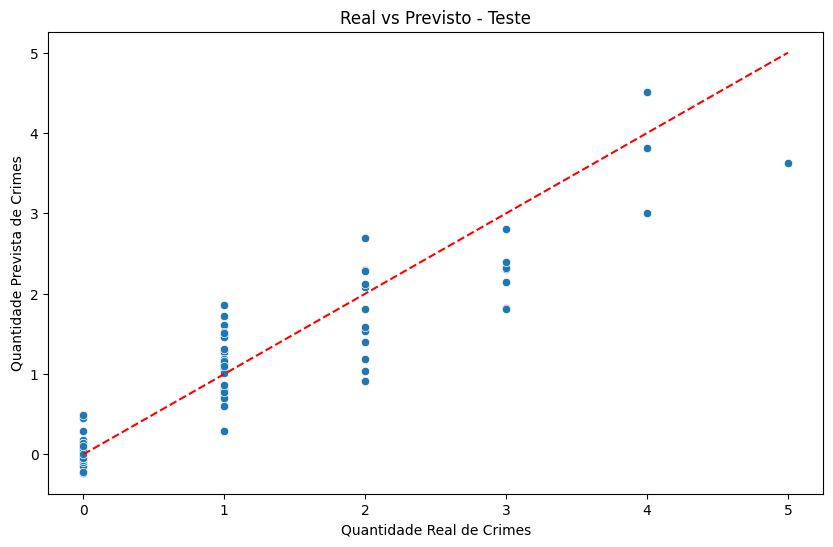

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Exemplo de gráfico comparando real x previsto
plt.figure(figsize=(10,6))
sns.scatterplot(x=y_test, y=y_pred)
plt.plot([0, max(y_test)], [0, max(y_test)], 'r--')  
plt.xlabel("Quantidade Real de Crimes")
plt.ylabel("Quantidade Prevista de Crimes")
plt.title("Real vs Previsto - Teste")
plt.show()


*A linha vermelha parece seguir uma tendência crescente. Isso indica que à medida que a quantidade real de crimes aumenta, o modelo também prevê um aumento na quantidade de crimes, o que é um bom sinal de que o modelo está capturando uma tendência.*

*o fato de os pontos não estarem perfeitamente alinhados à linha vermelha sugere que o modelo ainda tem erros de previsão.*

*Exemplo de previsão*

In [41]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def prever_e_grafico(modelo, df_full, ano, mes):

    
    bairros = df_full['bairro'].unique()
    dados_novos = []

    # Criar dataset de previsão com lags e features
    for bairro in bairros:
        lags = []
        for lag in range(1,7):
            prev_mes = mes - lag
            prev_ano = ano
            if prev_mes <= 0:
                prev_mes += 12
                prev_ano -= 1
            val = df_full[(df_full['bairro']==bairro) & 
                          (df_full['ano']==prev_ano) & 
                          (df_full['mes']==prev_mes)]['quantidade_crimes']
            if len(val) == 0:
                val = 0
            else:
                val = val.values[0]
            lags.append(val)
        
        # Features extras
        extra = df_full[(df_full['bairro']==bairro) & (df_full['ano']==ano) & (df_full['mes']==mes)]
        if extra.empty:
            vit = 0
            sus = 0
            arma = 'Nenhum'
        else:
            vit = extra['quantidade_vitimas'].values[0]
            sus = extra['quantidade_suspeitos'].values[0]
            arma = extra['arma_utilizada'].values[0]
        
        # Estação
        def estacao(mes):
            if mes in [12,1,2]: return "Verão"
            elif mes in [3,4,5]: return "Outono"
            elif mes in [6,7,8]: return "Inverno"
            else: return "Primavera"
        est = estacao(mes)
        
        dados_novos.append({
            'bairro': bairro,
            'ano': ano,
            'mes': mes,
            'lag1': lags[0],
            'lag2': lags[1],
            'lag3': lags[2],
            'lag4': lags[3],
            'lag5': lags[4],
            'lag6': lags[5],
            'quantidade_vitimas': vit,
            'quantidade_suspeitos': sus,
            'arma_utilizada': arma,
            'estacao': est
        })
    
    df_novos = pd.DataFrame(dados_novos)
    df_novos['previsao_crimes'] = modelo.predict(df_novos)
    
    # Gráfico
    plt.figure(figsize=(12,6))
    sns.barplot(data=df_novos, x='bairro', y='previsao_crimes', palette='Reds')
    plt.title(f"Previsão de Crimes de Tráfico - {mes}/{ano}")
    plt.ylabel("Quantidade Prevista de Crimes")
    plt.xlabel("Bairro")
    plt.ylim(0, df_novos['previsao_crimes'].max()+2)
    plt.show()
    
    return df_novos[['bairro','ano','mes','previsao_crimes']]


*Prever o um tráfico de drogas*

C:\Users\55819\AppData\Local\Temp\ipykernel_9512\59826488.py:69: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_novos, x='bairro', y='previsao_crimes', palette='Reds')


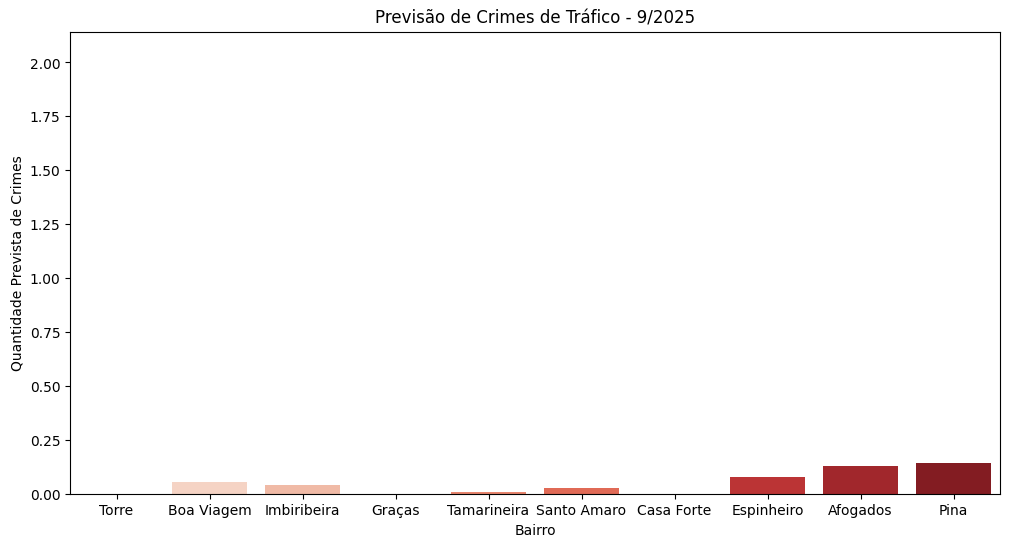

        bairro   ano  mes  previsao_crimes
0        Torre  2025    9        -0.118147
1   Boa Viagem  2025    9         0.055953
2  Imbiribeira  2025    9         0.041333
3       Graças  2025    9         0.000642
4  Tamarineira  2025    9         0.007476
5  Santo Amaro  2025    9         0.027557
6   Casa Forte  2025    9        -0.010340
7   Espinheiro  2025    9         0.075889
8     Afogados  2025    9         0.129407
9         Pina  2025    9         0.142519


In [42]:
# Prever crimes para setembro de 2025
previsoes = prever_e_grafico(model, df_full, 2025, 9)
print(previsoes)


*Insight - Áreas com Alto Risco de Tráfico de Drogas*

Com base na análise de dados, observamos que os bairros *Pina*, *Afogados* e *Espinheiro* apresentam *alto risco* de tráfico de drogas. Esses bairros estão entre os que mais frequentemente registram atividades relacionadas a crimes, o que indica uma necessidade urgente de ações preventivas.

*Recomendação:*
É essencial aumentar a presença de *viaturas* e *policiais* nesses bairros, com o objetivo de:

- *Inibir a prática de crimes* relacionados ao tráfico de drogas;
- *Aumentar a segurança* para os moradores e frequentadores da região;
- *Monitorar* atividades suspeitas de forma contínua e eficiente.

A presença policial reforçada pode ajudar a **diminuir a criminalidade** e promover um ambiente mais seguro para a comunidade.
